In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from scipy.stats import mannwhitneyu
import numpy as np

# Load the data

In [3]:
files = os.listdir('annotated_prompts')
df = pd.concat([pd.read_csv(f'annotated_prompts/{file}') for file in files])
df.head()

,Category,query,Response,MODEL,Human-like rate,Response Relevance - rate,Clarity & coherence,Annotator,Response
0,Ending a long-term friendship,I feel our friendship has become one-sided and...,"Hi, there's something I need to talk to you ab...",Claude,3.0,3.0,5.0,Bella,NaN
1,Disappointment Prompts,I had a bad experience with my landlord. Iג€™v...,"Hi, I've been reporting issues with my apartme...",Claude,3.0,5.0,5.0,Bella,NaN
2,Service Cancellation Prompts,Iג€™ve been using the same landscaper for a wh...,"""Hey, I wanted to let you know that I've decid...",Friends RAG,4.0,5.0,5.0,Bella,NaN
3,Break Up,"Iג€™ve been in a relationship for a year, but ...","Hey, I hope you're doing alright. There's some...",Claude,5.0,5.0,5.0,Bella,NaN
4,Addressing a friend who frequently cancels plans,"My friend keeps canceling plans last minute, a...","Hey, I wanted to talk to you about something t...",Friends RAG,4.0,5.0,5.0,Bella,NaN


In [4]:
# Drop redundant column
df.drop(columns=['Response '], inplace=True)

In [5]:
# Rename annotators
df['Annotator'] = df['Annotator'].apply(lambda x: 'Or' if x == 'OR' else 'Bella' if x == 'BELLA' else x)
df['Annotator'].unique()

array(['Bella', 'Or', 'Tomer'], dtype=object)

In [6]:
# Prepare colors for graphs
colors = sns.color_palette('Set3', n_colors=3)
models_map = {'Claude': colors[0], 'Friends RAG': colors[1], 'GPT': colors[2]}
annoators_map = {'Or': colors[0], 'Bella': colors[1], 'Tomer': colors[2]}

# Scores Distribution

## Human Like Score

In [7]:
# drop the rows with missing values
df.dropna(subset=[' Human-like rate'], inplace=True)

In [8]:
def plot_distribution_per_model(data, column):
    """Plot the distribution of the scores for each model using a histogram, a KDE, and a boxplot.
       Args:
       data (pd.DataFrame): The data to plot
       column (str): The column to plot
    """
    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))

    # Plot the histogram of the scores for each model without individual legends
    sns.histplot(data=data, x=column, hue='MODEL', kde=True, palette=models_map, ax=axs[0], legend=False)
    axs[0].set(title= f'{column} Score Histogram')

    # Plot the KDE of the scores for each model without individual legends
    sns.kdeplot(data=data, x=column, hue='MODEL', common_norm=False, palette=models_map, ax=axs[1], legend=False)
    axs[1].set(title= f'{column} Score KDE')

    # Plot the boxplot of the scores for each model without individual legends
    sns.boxplot(data=data, x='MODEL', y=column, hue='MODEL', palette=models_map, ax=axs[2], dodge=False)
    axs[2].set(title= f'{column} Score Boxplot')

    # Add a combined legend outside the subplots
    handles = [plt.Line2D([0], [0], color=color, lw=4) for color in models_map.values()]
    labels = list(models_map.keys())
    fig.legend(handles, labels, loc='lower center', ncol=len(models_map), title="Model", bbox_to_anchor=(0.5, -0.15))

    # Set the title and display the plot
    plt.suptitle(f'{column} Score Distribution per Model', y=1.05, fontsize=20)
    plt.tight_layout()
    plt.show()

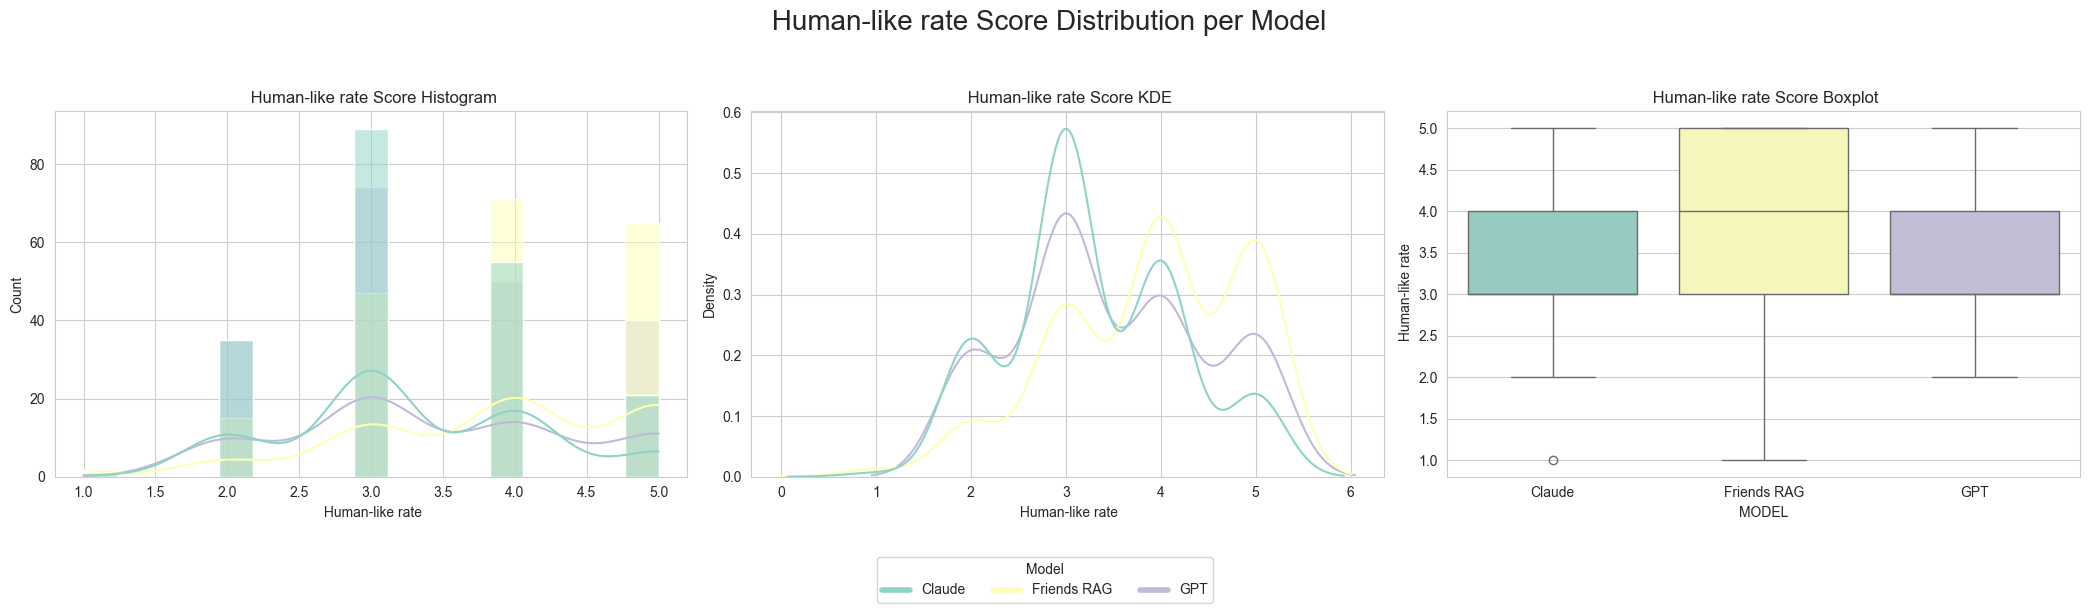

In [9]:
plot_distribution_per_model(df, ' Human-like rate')

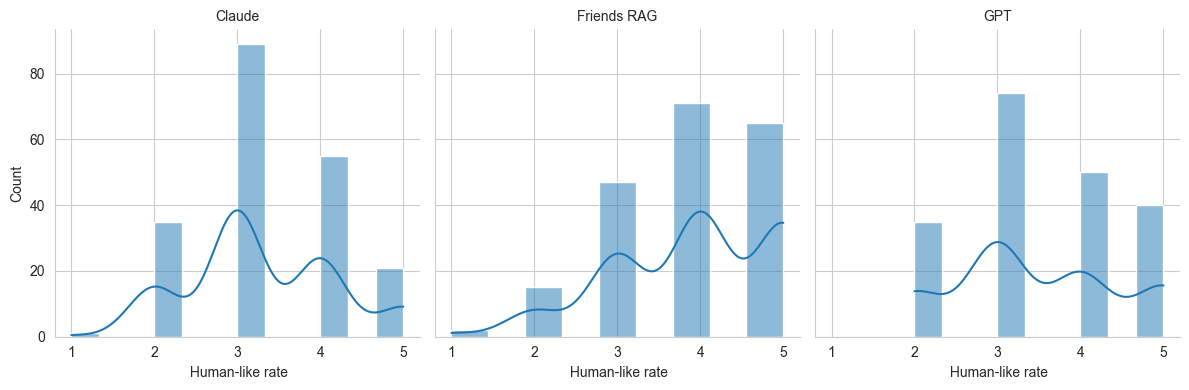

In [10]:
g = sns.FacetGrid(df, col="MODEL", col_wrap=3, height=4, sharex=True, sharey=True)
g.map(sns.histplot, ' Human-like rate', kde=True)
g.set_titles("{col_name}")

### Check Statistical Significance

In [11]:
def compare_models(df, model_a, model_b, rate_column=' Human-like rate'):
    """Compare two models using the Mann-Whitney U test.
       Args:
       df (pd.DataFrame): The data
       model_a (str): The first model to compare
       model_b (str): The second model to compare
       rate_column (str): The column to compare"""
    model_a_scores = df[df['MODEL'] == model_a][rate_column]
    model_b_scores = df[df['MODEL'] == model_b][rate_column]
    stat, p_value = mannwhitneyu(model_a_scores, model_b_scores, alternative='greater')
    print(f"{model_a} vs {model_b} - Mann-Whitney U statistic: {stat}, p-value: {p_value}")
    if p_value <= 0.05:
        print(f"Model {model_a} is significantly better than Model {model_b} regarding {rate_column}")
    else:
        print(f"Model '{model_a}' is not significantly better than Model '{model_b}' regarding {rate_column}")
    return p_value

In [12]:
p_val = compare_models(df, 'Friends RAG', 'Claude')

Friends RAG vs Claude - Mann-Whitney U statistic: 27272.0, p-value: 5.6180512727835806e-11
Model Friends RAG is significantly better than Model Claude regarding  Human-like rate


In [13]:
p_val = compare_models(df, 'Friends RAG', 'GPT')

Friends RAG vs GPT - Mann-Whitney U statistic: 24795.5, p-value: 4.910625844614301e-06
Model Friends RAG is significantly better than Model GPT regarding  Human-like rate


### Calculate CIs

In [14]:
def bootstrap_mean_diff(scores_a, scores_b, n_bootstrap=1000):
    """Calculate bootstrapped mean differences between two samples.
       Args:
       scores_a (np.array): The first sample
       scores_b (np.array): The second sample
       n_bootstrap (int): The number of bootstrap iterations
       """
    boot_diffs = []
    for _ in range(n_bootstrap):
        sample_a = np.random.choice(scores_a, size=len(scores_a), replace=True)
        sample_b = np.random.choice(scores_b, size=len(scores_b), replace=True)
        boot_diffs.append(sample_a.mean() - sample_b.mean())
    return boot_diffs

In [15]:
def calculate_ci(boot_diffs, ci=95):
    """Calculate confidence interval bounds for bootstrapped mean differences.
       Args:
        boot_diffs (np.array): The bootstrapped mean differences
        ci (int): The confidence interval percentage
        """
    mean_diff = np.mean(boot_diffs)
    lower_bound = np.percentile(boot_diffs, (100 - ci) / 2)
    upper_bound = np.percentile(boot_diffs, 100 - (100 - ci) / 2)
    return mean_diff, lower_bound, upper_bound

In [16]:
def compare_model_differences(data, score_column, model_column='MODEL', ci=95, n_bootstrap=1000):
    """Calculate and plot confidence intervals for score differences between models.
       Args:
        data (pd.DataFrame): The data
        score_column (str): The column to compare
        model_column (str): The column with the model names
        ci (int): The confidence interval percentage
        n_bootstrap (int): The number of bootstrap iterations
        """
    ci_results = []

    # Loop through model pairs
    model_a = 'Friends RAG'
    for model_b in ['Claude', 'GPT']:
        scores_a = data.loc[data[model_column] == model_a, score_column].values
        scores_b = data.loc[data[model_column] == model_b, score_column].values
        boot_diffs = bootstrap_mean_diff(scores_a, scores_b, n_bootstrap)
        mean_diff, lower, upper = calculate_ci(boot_diffs, ci)
        
        ci_results.append({
            'Model A': model_a, 'Model B': model_b,
            'Mean Difference': mean_diff,
            f'{ci}% CI Lower': lower, f'{ci}% CI Upper': upper
        })

    ci_df = pd.DataFrame(ci_results)
    plot_ci_results(ci_df, ci, score_column)
    return ci_df

In [17]:
def plot_ci_results(ci_df, ci, score_column):
    """Plot confidence intervals for model score differences.
       Args:
        ci_df (pd.DataFrame): The confidence interval results
        ci (int): The confidence interval percentage"""
    plt.figure(figsize=(12, 4))
    for idx, row in ci_df.iterrows():
        plt.plot([row[f'{ci}% CI Lower'], row[f'{ci}% CI Upper']], [idx, idx], color='gray')
        plt.plot(row['Mean Difference'], idx, 'o', color='lightblue')
    plt.xlim(-1, 1)
    plt.axvline(0, color='red', linestyle='--')
    plt.yticks(range(len(ci_df)), [f"{row['Model A']} - {row['Model B']}" for _, row in ci_df.iterrows()])
    plt.title(f'{score_column} {ci}% Confidence Intervals for Model Score Differences')
    plt.xlabel('Score Difference')
    plt.ylabel('Models Pair')
    plt.show()

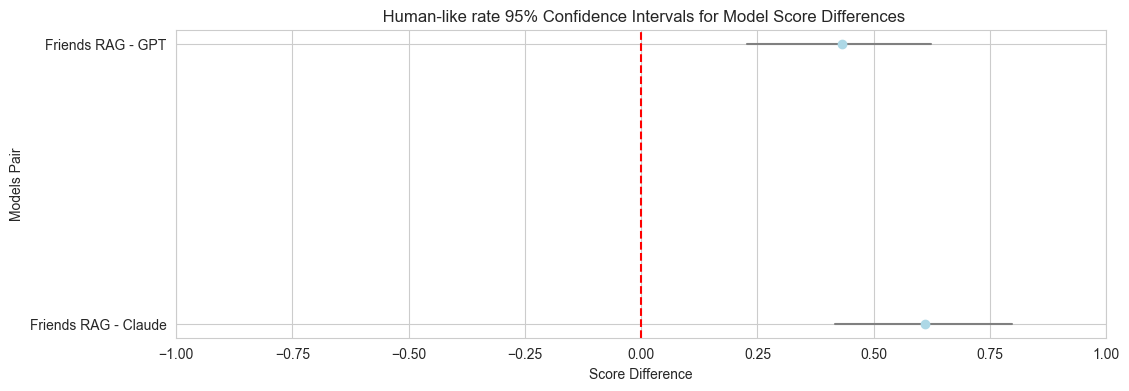

,Model A,Model B,Mean Difference,95% CI Lower,95% CI Upper
0,Friends RAG,Claude,0.610472,0.417063,0.796682
1,Friends RAG,GPT,0.432255,0.227582,0.623187


In [18]:
ci_df = compare_model_differences(data=df, score_column=' Human-like rate')
ci_df

### Check per Annotator

In [19]:
def compare_annotators(df, rate_column=' Human-like rate'):
    """Compare the scores of the annotators using the Mann-Whitney U test.
       Args:
         df (pd.DataFrame): The data
            rate_column (str): The column to compare
    """
    # Histogram of the scores per annotator
    sns.histplot(data=df, x=rate_column, hue='Annotator', kde=True, palette=annoators_map)
    plt.title(f'{rate_column} Histogram per Annotator')

    # Add a custom legend outside the main histogram plot
    handles = [plt.Line2D([0], [0], color=color, lw=4) for color in annoators_map.values()]
    labels = list(annoators_map.keys())
    plt.legend(handles, labels, title="Annotator", bbox_to_anchor=(0.5, -0.5), loc='lower center')
    plt.show()

    # Compare the scores of the annotators per model
    g = sns.FacetGrid(df, col="MODEL", col_wrap=3, height=6, sharex=True, sharey=True, legend_out=True)
    g.map_dataframe(sns.histplot, x=rate_column, hue='Annotator', kde=True, palette=annoators_map)
    g.set_titles("{col_name}")
    plt.suptitle(f'{rate_column} Histogram per Annotator and Model', y=1.05, fontsize=20)
    plt.tight_layout()
    plt.show()


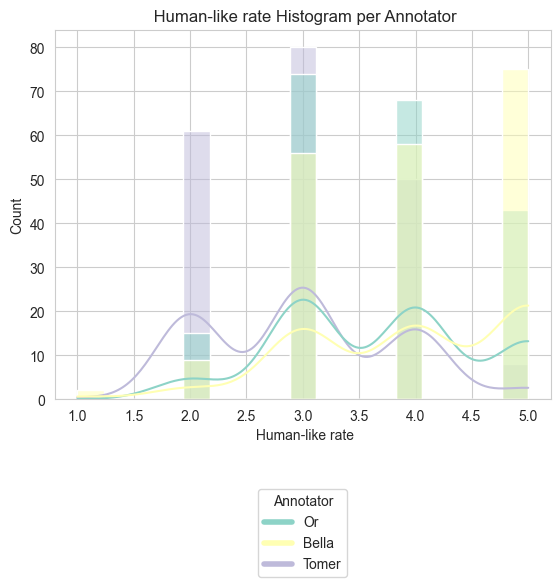

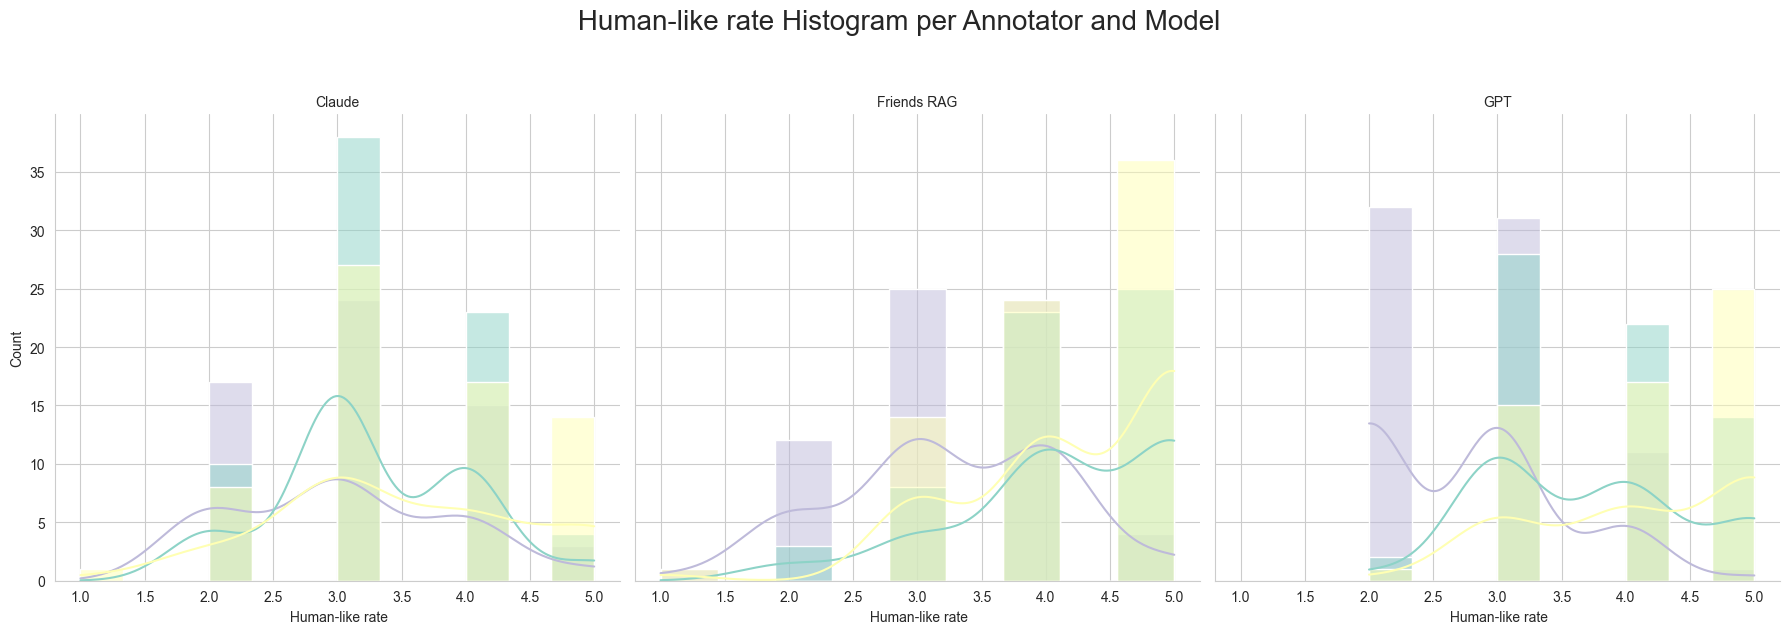

In [20]:
compare_annotators(df)

### Per Category

Friends RAG vs Claude - Mann-Whitney U statistic: 23.0, p-value: 0.19443060701781328
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding  Human-like rate
Addressing a friend who frequently cancels plans is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 12.5, p-value: 0.8469719602543117
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding  Human-like rate
Addressing someone whoג€™s not paying you back is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 33.0, p-value: 0.007250524311939799
Model Friends RAG is significantly better than Model Claude regarding  Human-like rate
Friends RAG vs GPT - Mann-Whitney U statistic: 31.5, p-value: 0.014818031030539577
Model Friends RAG is significantly better than Model GPT regarding  Human-like rate
Category Asking a coworker to stop copying your work is significantly better 

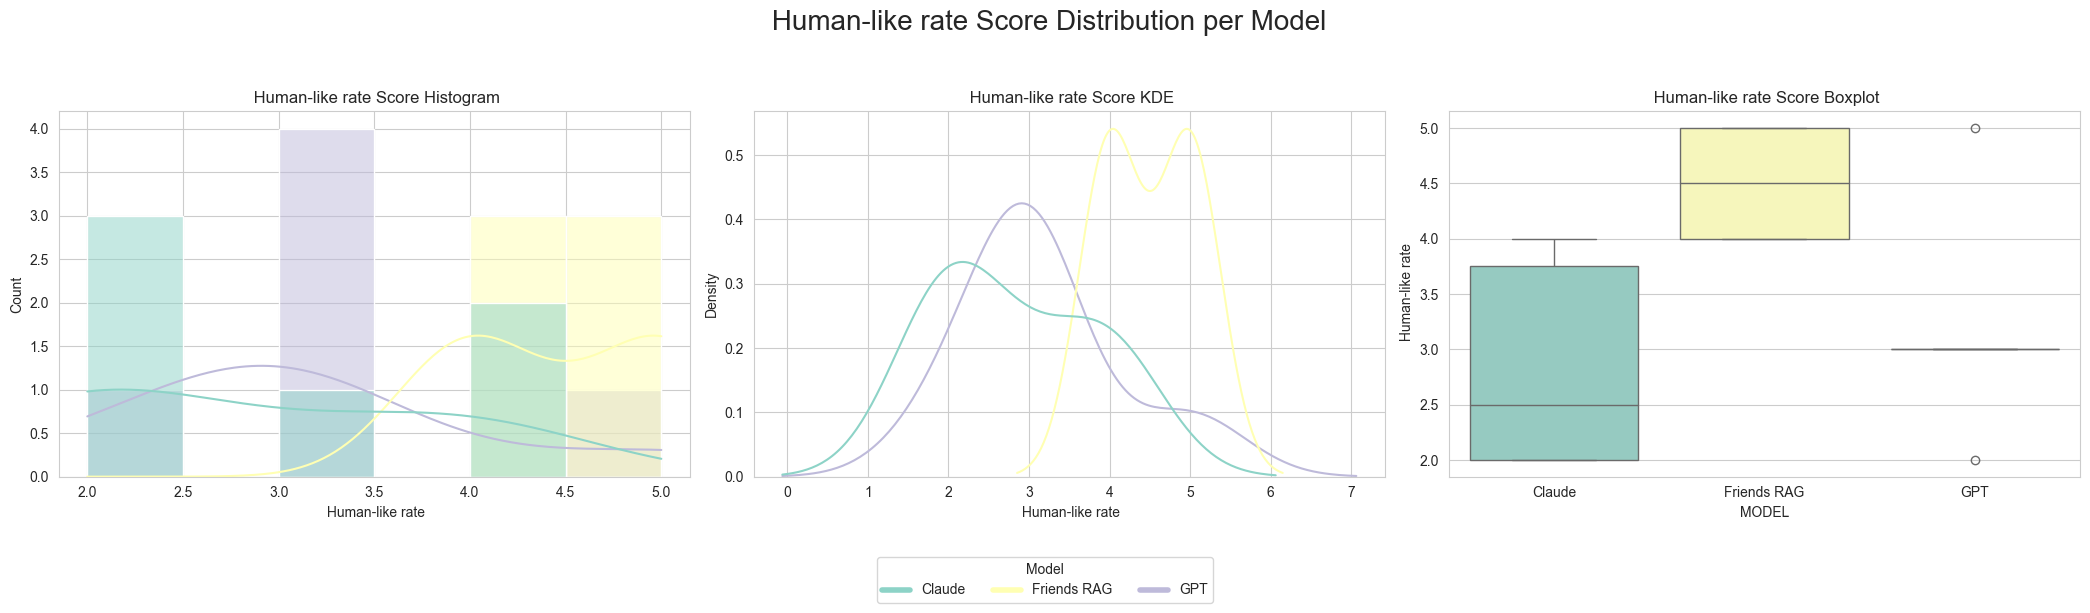

Friends RAG vs Claude - Mann-Whitney U statistic: 21.5, p-value: 0.30223968051885486
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding  Human-like rate
Asking a neighbor to stop being too loud is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 22.5, p-value: 0.25289490746934595
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding  Human-like rate
Asking someone to stop oversharing personal details is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 350.5, p-value: 0.08877648556664508
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding  Human-like rate
Break Up is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 30.5, p-value: 0.022341892981261924
Model Friends RAG is significantly better than Model Claude regarding  Human-li

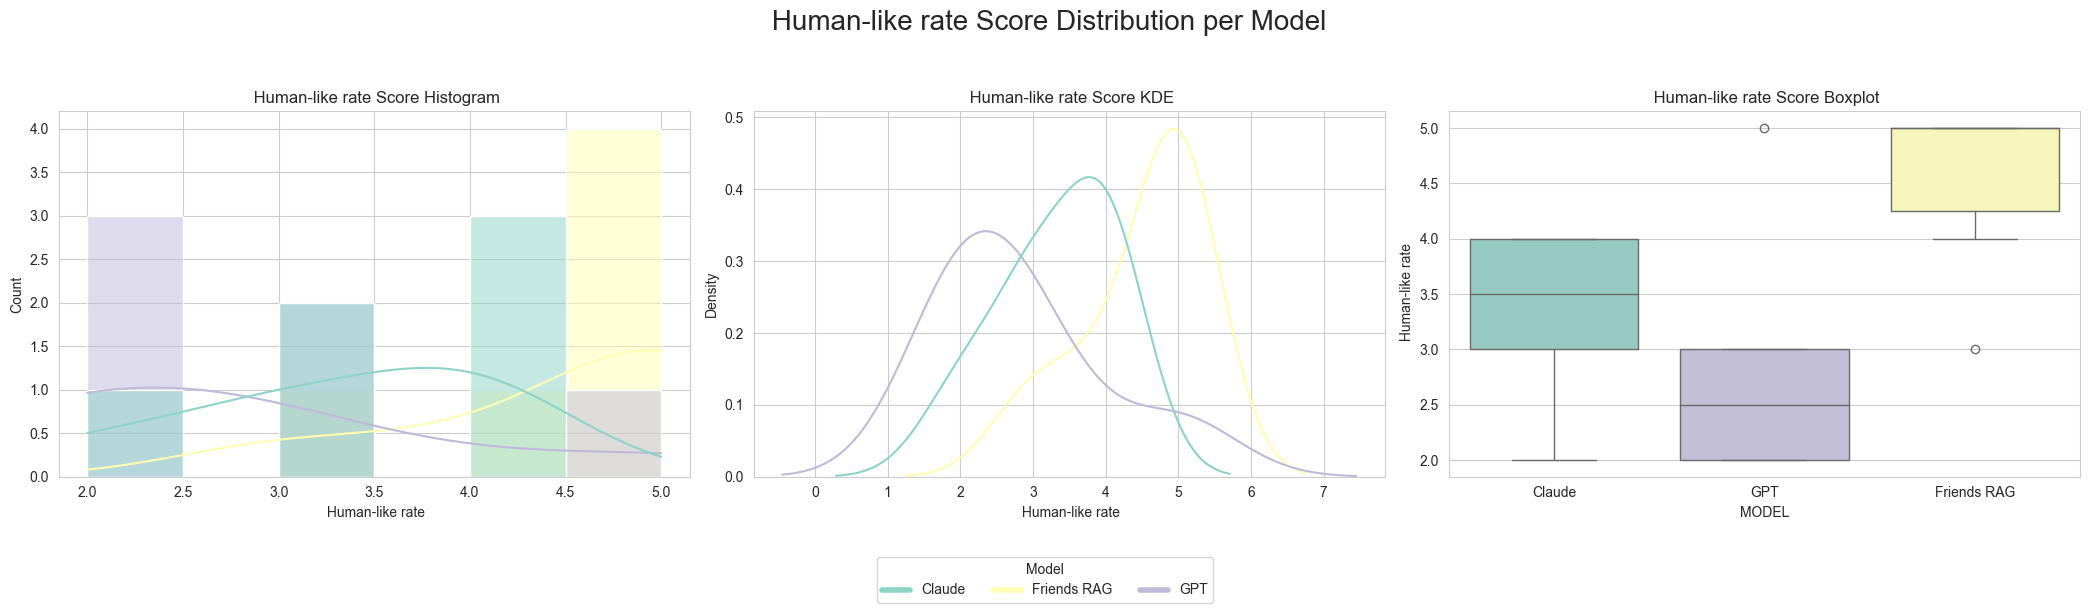

Friends RAG vs Claude - Mann-Whitney U statistic: 17.5, p-value: 0.7242950511528562
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding  Human-like rate
Cancelling plans last minute is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 30.0, p-value: 0.019582975804513323
Model Friends RAG is significantly better than Model Claude regarding  Human-like rate
Friends RAG vs GPT - Mann-Whitney U statistic: 22.0, p-value: 0.2703333372061887
Model 'Friends RAG' is not significantly better than Model 'GPT' regarding  Human-like rate
Confronting a family member about overstepping boundaries is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 28.5, p-value: 0.044959665089480426
Model Friends RAG is significantly better than Model Claude regarding  Human-like rate
Friends RAG vs GPT - Mann-Whitney U statistic: 27.0, p-value: 0.06907351464807476
Model

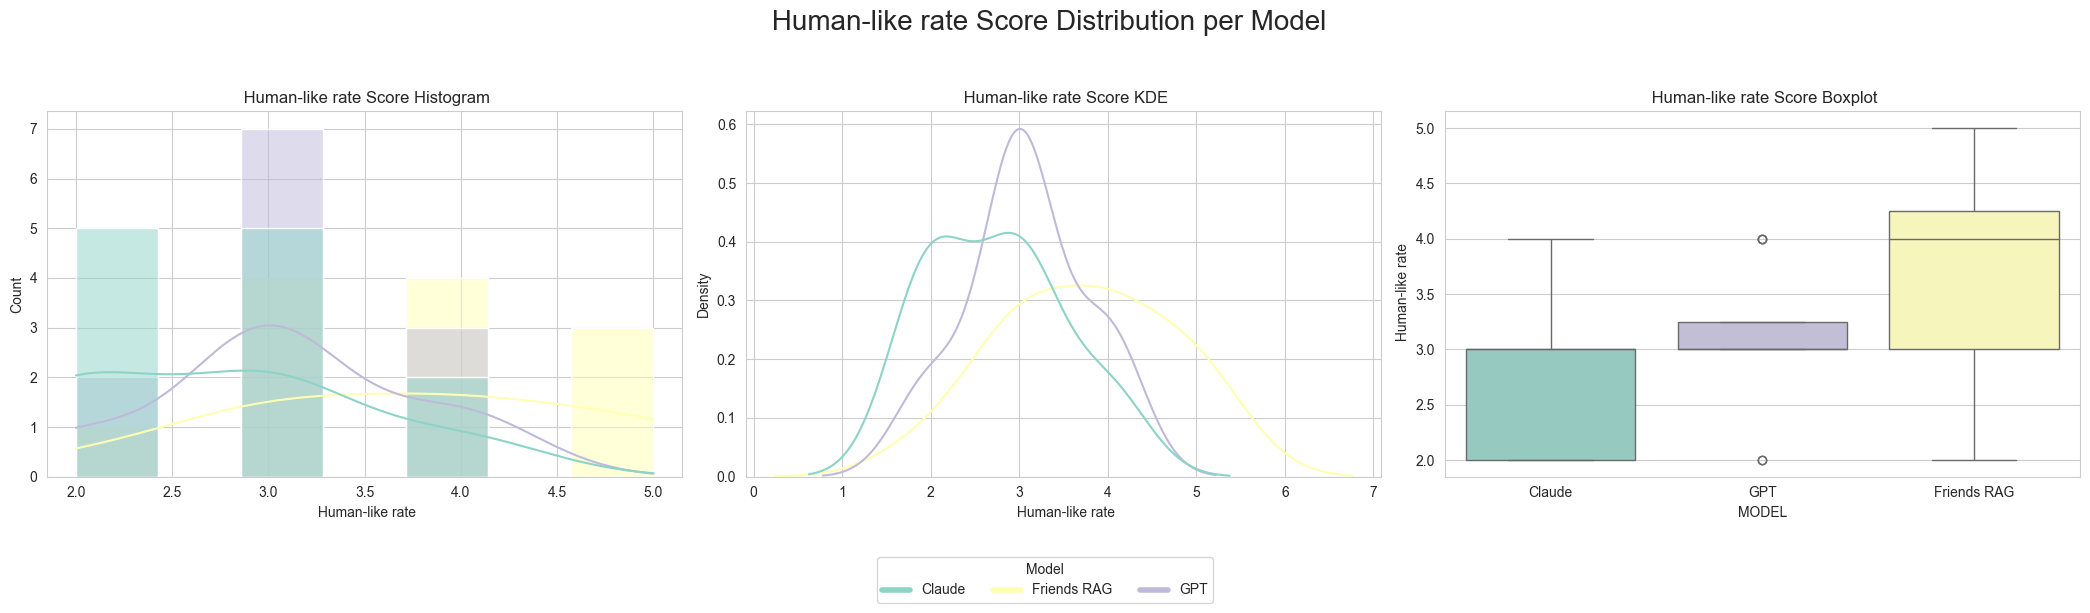

Friends RAG vs Claude - Mann-Whitney U statistic: 24.0, p-value: 0.17548670176940195
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding  Human-like rate
Ending a mentorship or advising relationship is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 24.0, p-value: 0.17213182846626524
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding  Human-like rate
Informing someone that their gift wasnג€™t well-received is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 41.5, p-value: 0.012720240021901906
Model Friends RAG is significantly better than Model Claude regarding  Human-like rate
Friends RAG vs GPT - Mann-Whitney U statistic: 30.0, p-value: 0.23349263067339204
Model 'Friends RAG' is not significantly better than Model 'GPT' regarding  Human-like rate
Pushy Parents is not significantly better for Friends RAG than 

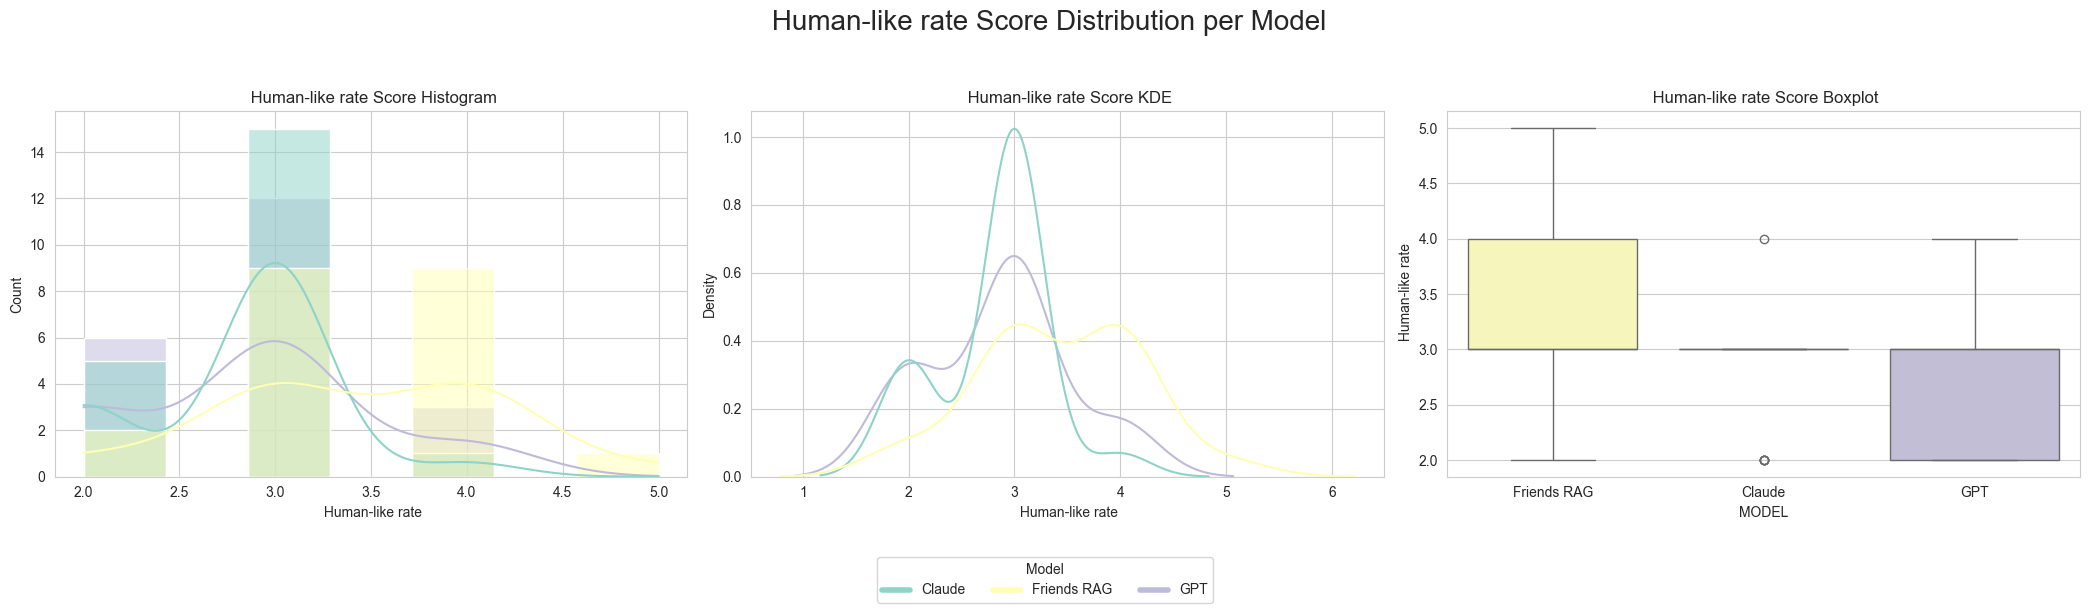

Friends RAG vs Claude - Mann-Whitney U statistic: 52.0, p-value: 0.13333773311743657
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding  Human-like rate
Telling a friend you don't want to go into business with them is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 26.5, p-value: 0.09038096785779565
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding  Human-like rate
Telling a roommate they need to move out is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 15.0, p-value: 0.7224305850723746
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding  Human-like rate
Telling someone you no longer want to be their bridesmaid/groomsman is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 24.5, p-value: 0.15680814930170772
Model 'Friend

In [21]:
# Compare the models per category
for category, category_df in df.groupby('Category'):
    if compare_models(category_df, 'Friends RAG', 'Claude') <= 0.05 and compare_models(category_df, 'Friends RAG', 'GPT') <= 0.05:
        print(f'Category {category} is significantly better for Friends RAG than Claude and GPT')
        plot_distribution_per_model(category_df, ' Human-like rate')
    else:
        print(category + ' is not significantly better for Friends RAG than Claude and GPT')

## Relevance Score

### Distribution per Model

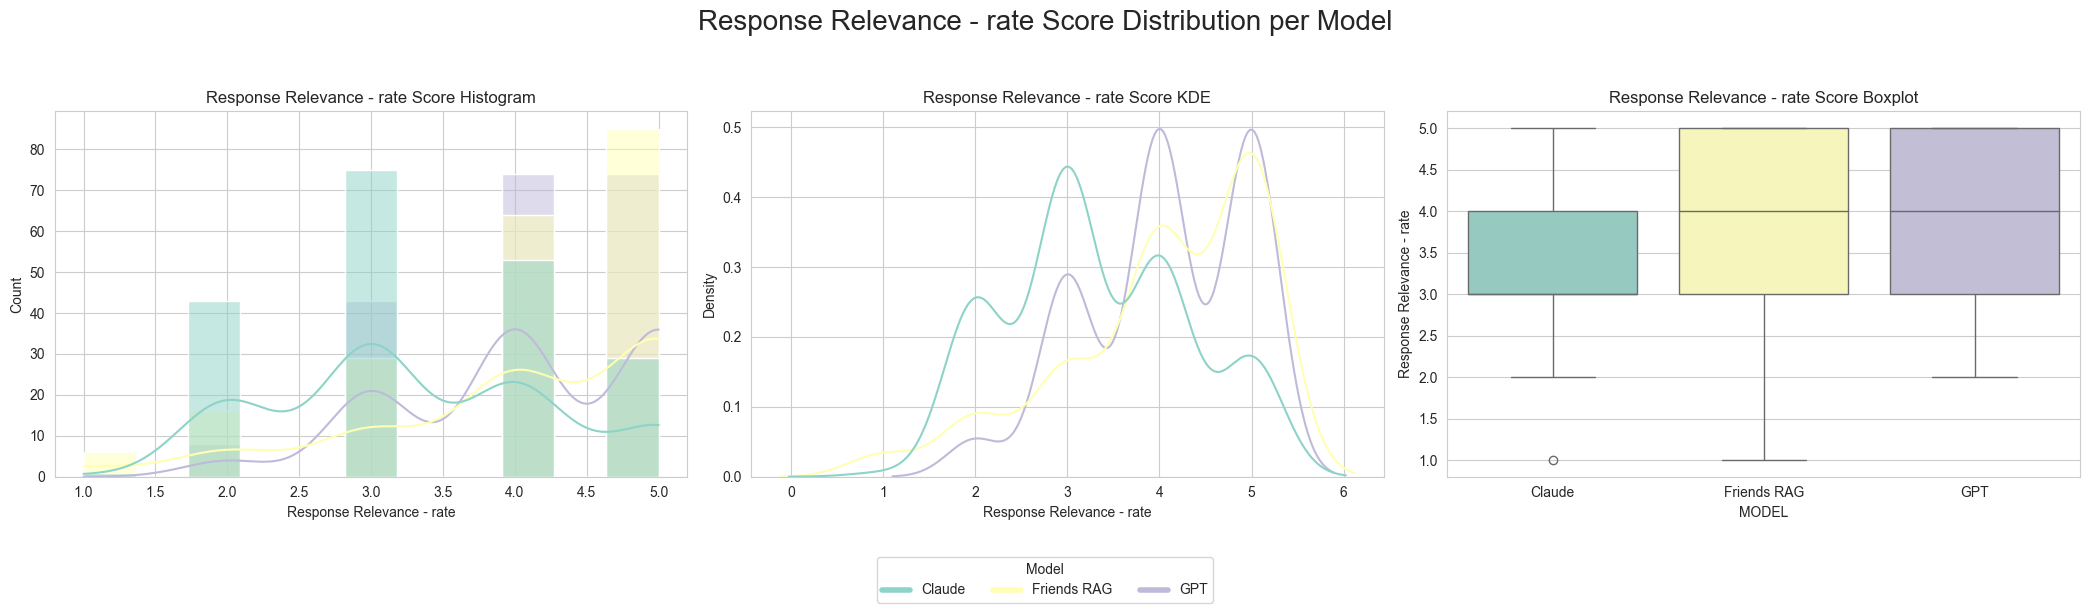

In [35]:
# Drop the rows with missing values
df.dropna(subset=['Response Relevance - rate'], inplace=True)

# Plot the distribution of the relevance scores for each model
plot_distribution_per_model(df, 'Response Relevance - rate')

### Check Statistical Significance

In [23]:
p_val = compare_models(df, 'Friends RAG', 'Claude', rate_column='Response Relevance - rate')

Friends RAG vs Claude - Mann-Whitney U statistic: 27891.0, p-value: 1.757142016654565e-12
Model Friends RAG is significantly better than Model Claude regarding Response Relevance - rate


In [24]:
p_val = compare_models(df, 'Friends RAG', 'GPT', rate_column='Response Relevance - rate')

Friends RAG vs GPT - Mann-Whitney U statistic: 20321.5, p-value: 0.34915459032540663
Model 'Friends RAG' is not significantly better than Model 'GPT' regarding Response Relevance - rate


### Calculate CIs

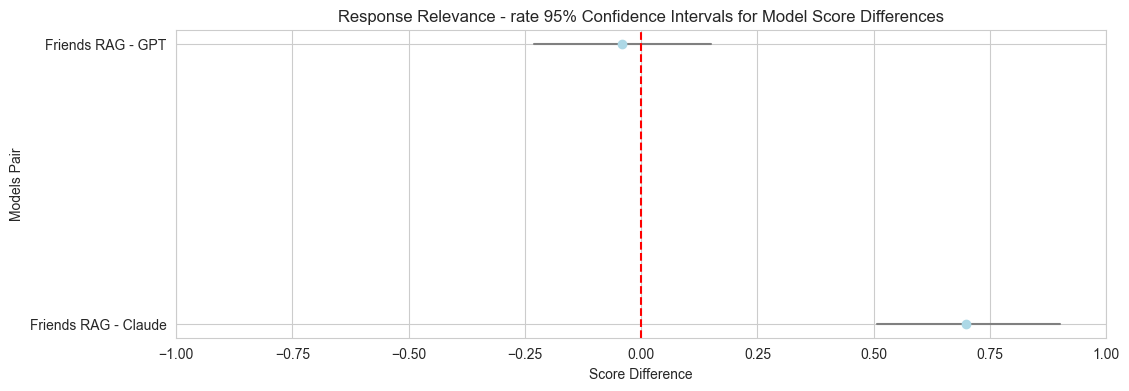

,Model A,Model B,Mean Difference,95% CI Lower,95% CI Upper
0,Friends RAG,Claude,0.699270,0.507208,0.901127
1,Friends RAG,GPT,-0.042263,-0.230707,0.150430


In [36]:
ci_df = compare_model_differences(data=df, score_column='Response Relevance - rate')
ci_df

### Check per Annotator

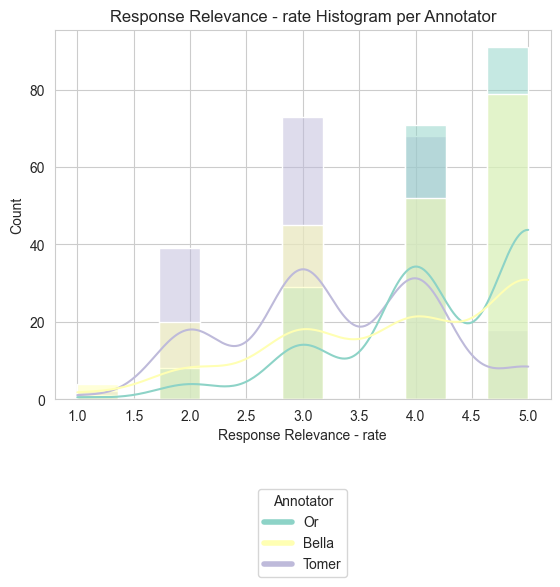

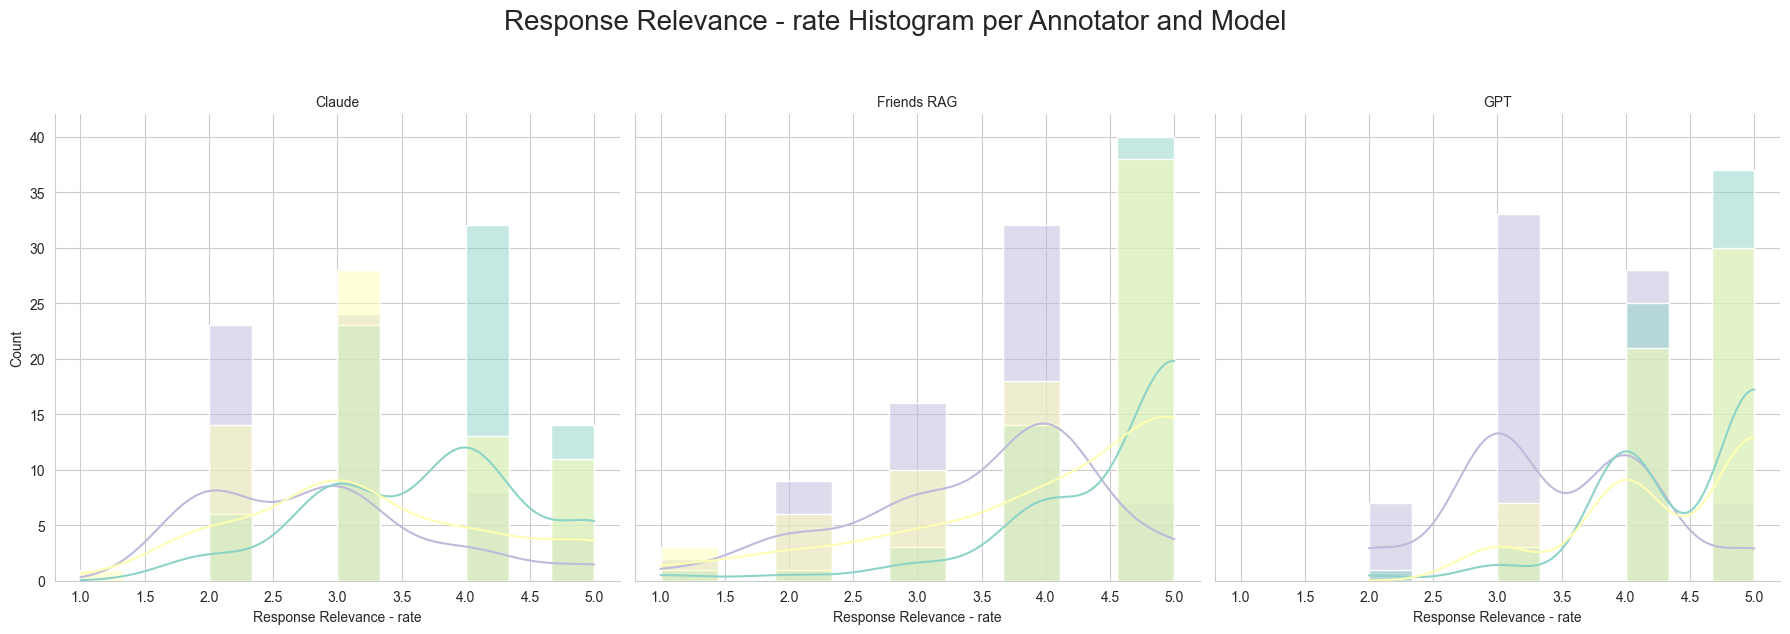

In [37]:
compare_annotators(df, rate_column='Response Relevance - rate')

### Per Category

Friends RAG vs Claude - Mann-Whitney U statistic: 33.0, p-value: 0.004654853106805908
Model Friends RAG is significantly better than Model Claude regarding Response Relevance - rate
Friends RAG vs GPT - Mann-Whitney U statistic: 33.0, p-value: 0.00405655863278289
Model Friends RAG is significantly better than Model GPT regarding Response Relevance - rate
Category Addressing a friend who frequently cancels plans is significantly better for Friends RAG than Claude and GPT


C:\Users\orco\AppData\Local\Temp\ipykernel_17944\3382584923.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=column, hue='MODEL', common_norm=False, palette=models_map, ax=axs[1], legend=False)


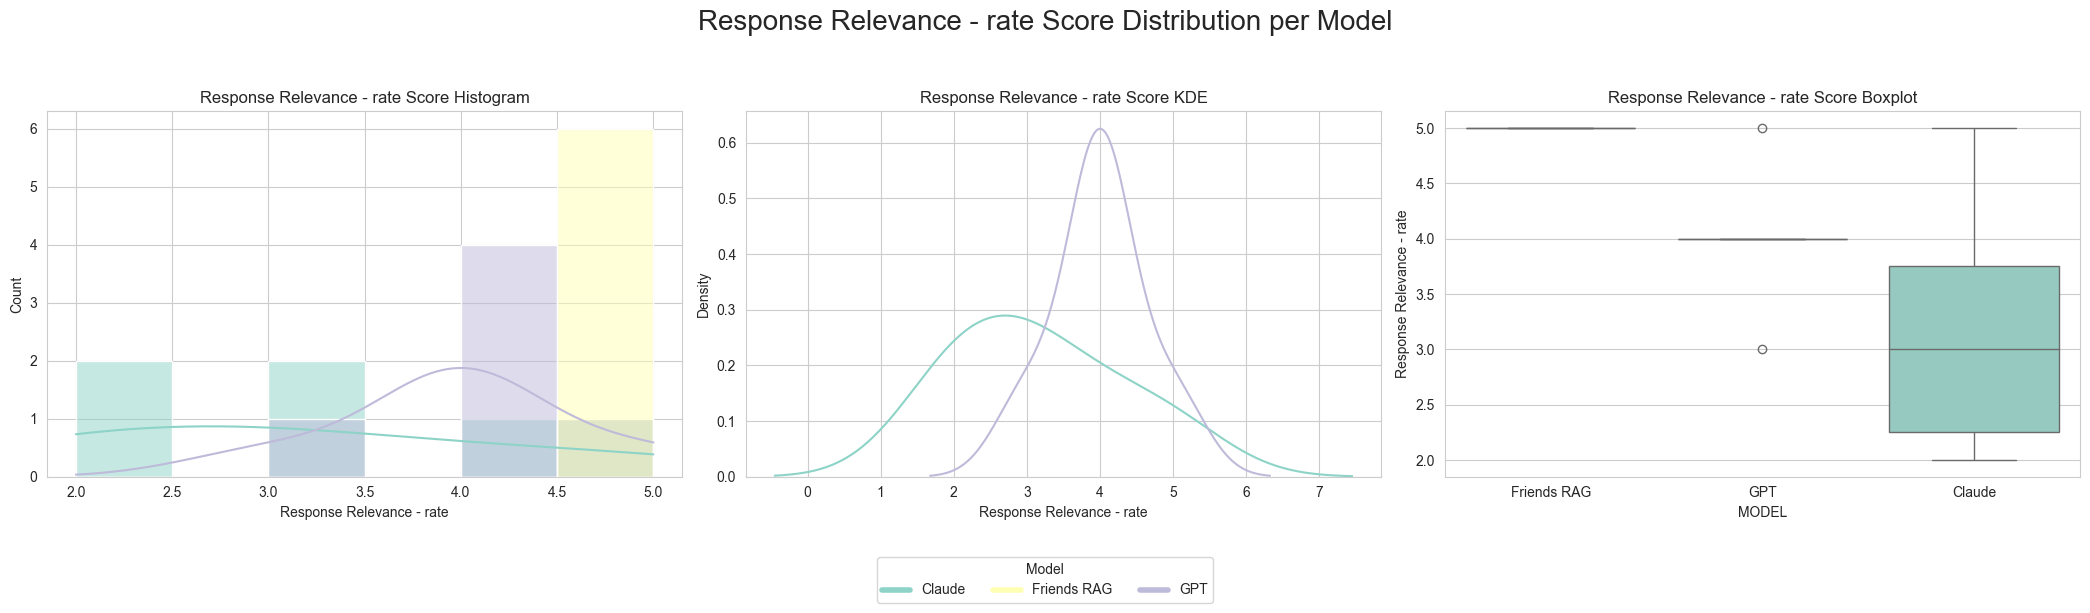

Friends RAG vs Claude - Mann-Whitney U statistic: 18.0, p-value: 0.5335897544090055
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding Response Relevance - rate
Addressing someone whoג€™s not paying you back is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 32.0, p-value: 0.011422632985522948
Model Friends RAG is significantly better than Model Claude regarding Response Relevance - rate
Friends RAG vs GPT - Mann-Whitney U statistic: 25.5, p-value: 0.11759874751464477
Model 'Friends RAG' is not significantly better than Model 'GPT' regarding Response Relevance - rate
Asking a coworker to stop copying your work is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 27.0, p-value: 0.06866435682294693
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding Response Relevance - rate
Asking a neighbor to stop being too lou

In [27]:
# Compare the models per category
for category, category_df in df.groupby('Category'):
    if compare_models(category_df, 'Friends RAG', 'Claude', 'Response Relevance - rate') <= 0.05 and compare_models(category_df, 'Friends RAG', 'GPT', 'Response Relevance - rate') <= 0.05:
        print(f'Category {category} is significantly better for Friends RAG than Claude and GPT')
        plot_distribution_per_model(category_df, 'Response Relevance - rate')
    else:
        print(category + ' is not significantly better for Friends RAG than Claude and GPT')

## Coherence Score

### Distribution per Model

In [28]:
df.columns

Index(['Category', 'query', 'Response', 'MODEL', ' Human-like rate',
       'Response Relevance - rate', 'Clarity & coherence', 'Annotator'],
      dtype='object')

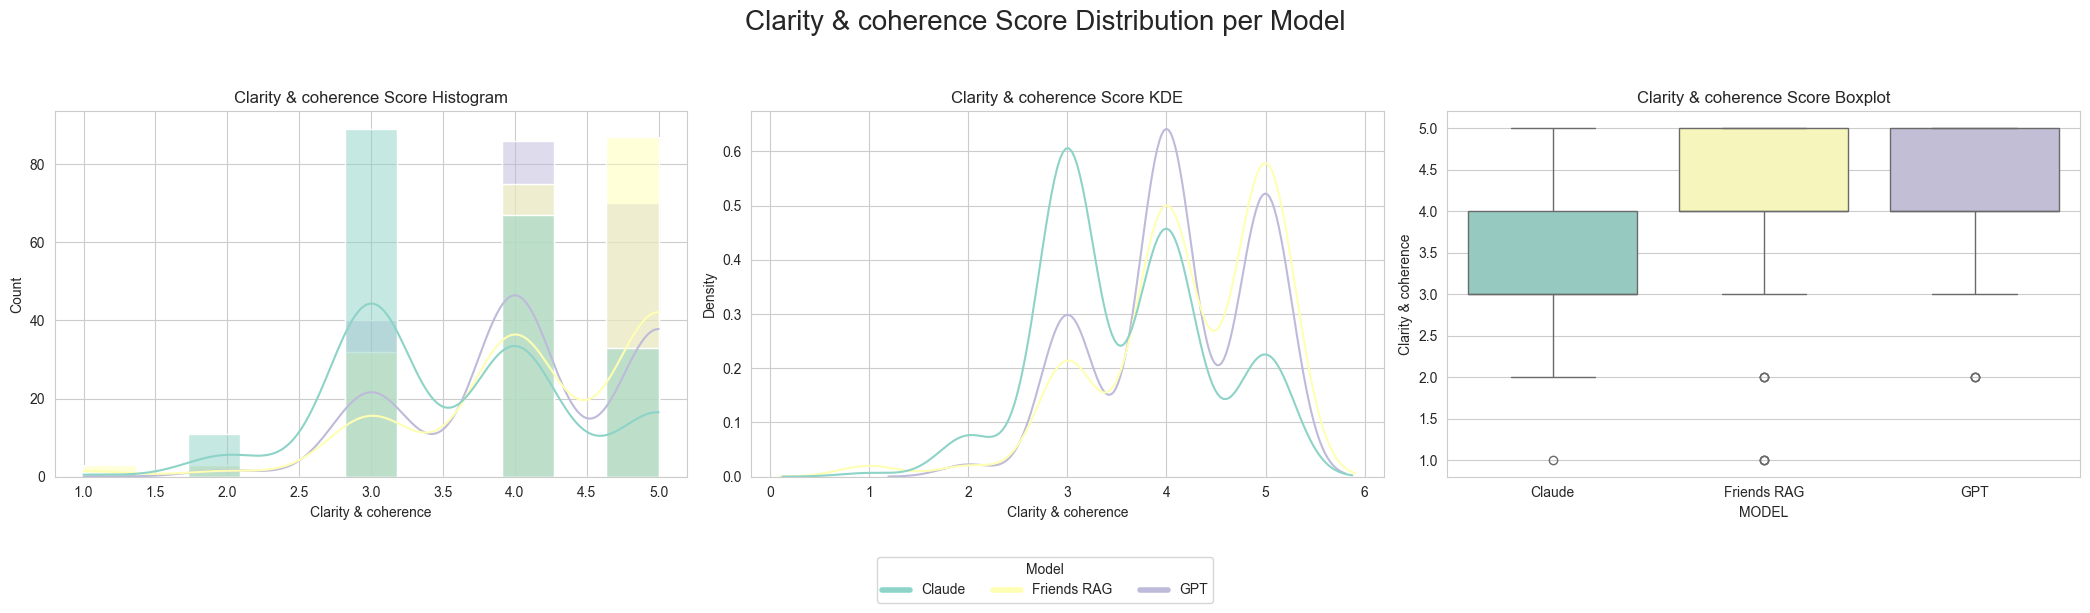

In [38]:
# Drop the rows with missing values
df.dropna(subset=['Clarity & coherence'], inplace=True)

# Plot the distribution of the coherence scores for each model
plot_distribution_per_model(df, 'Clarity & coherence')

### Check Statistical Significance

In [39]:
compare_models(df, 'Friends RAG', 'Claude', rate_column='Clarity & coherence')

Friends RAG vs Claude - Mann-Whitney U statistic: 27968.0, p-value: 4.626434724155552e-13
Model Friends RAG is significantly better than Model Claude regarding Clarity & coherence


4.626434724155552e-13

In [40]:
compare_models(df, 'Friends RAG', 'GPT', rate_column='Clarity & coherence')

Friends RAG vs GPT - Mann-Whitney U statistic: 21458.5, p-value: 0.07321165045332266
Model 'Friends RAG' is not significantly better than Model 'GPT' regarding Clarity & coherence


0.07321165045332266

### Calculate CIs

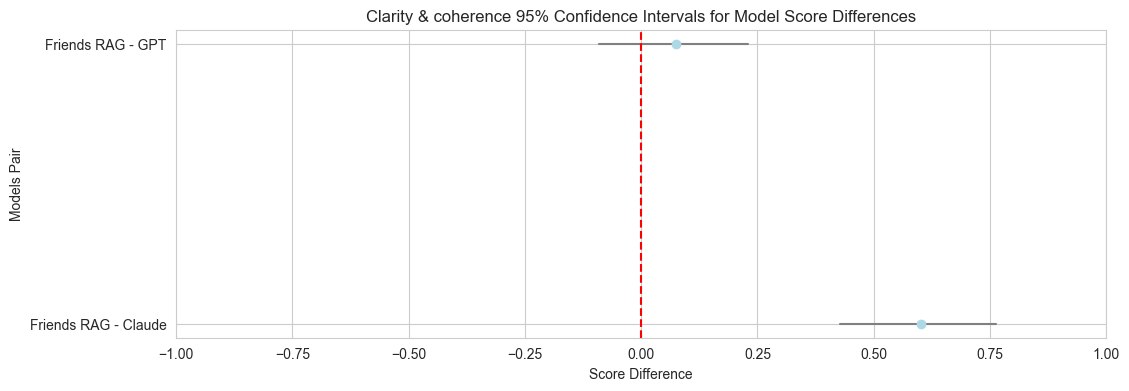

,Model A,Model B,Mean Difference,95% CI Lower,95% CI Upper
0,Friends RAG,Claude,0.601105,0.428529,0.762389
1,Friends RAG,GPT,0.074046,-0.091362,0.230188


In [41]:
ci_df = compare_model_differences(data=df, score_column='Clarity & coherence')
ci_df

### Check per Annotator

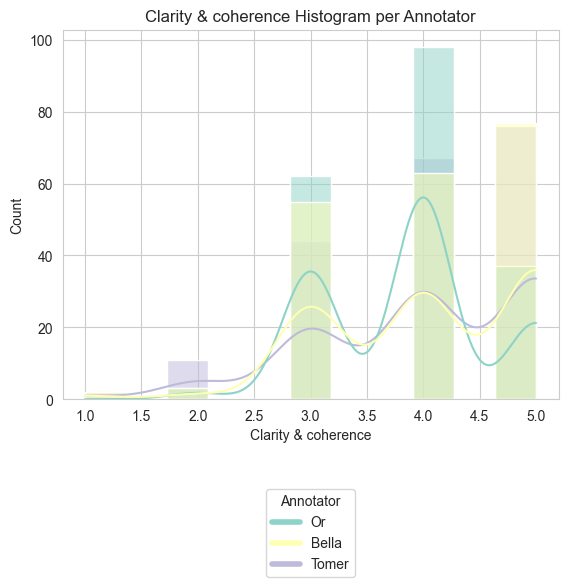

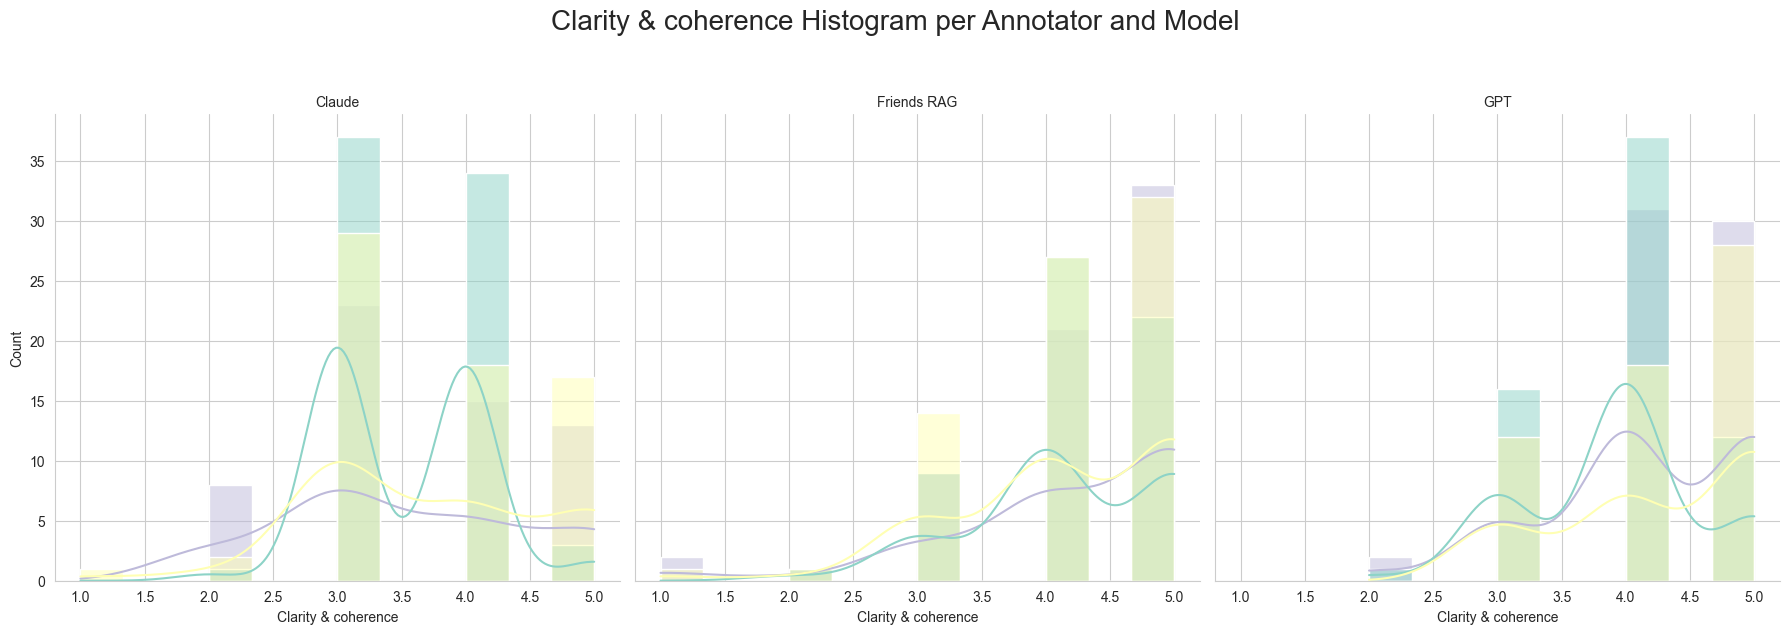

In [42]:
compare_annotators(df, rate_column='Clarity & coherence')

### Per Category

Friends RAG vs Claude - Mann-Whitney U statistic: 33.0, p-value: 0.006689143905797086
Model Friends RAG is significantly better than Model Claude regarding Clarity & coherence
Friends RAG vs GPT - Mann-Whitney U statistic: 25.0, p-value: 0.12340507663090577
Model 'Friends RAG' is not significantly better than Model 'GPT' regarding Clarity & coherence
Addressing a friend who frequently cancels plans is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 20.5, p-value: 0.35902416747342497
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding Clarity & coherence
Addressing someone whoג€™s not paying you back is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 20.5, p-value: 0.3664849638080658
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding Clarity & coherence
Asking a coworker to stop copying your work is not signifi

C:\Users\orco\AppData\Local\Temp\ipykernel_17944\3382584923.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=column, hue='MODEL', common_norm=False, palette=models_map, ax=axs[1], legend=False)


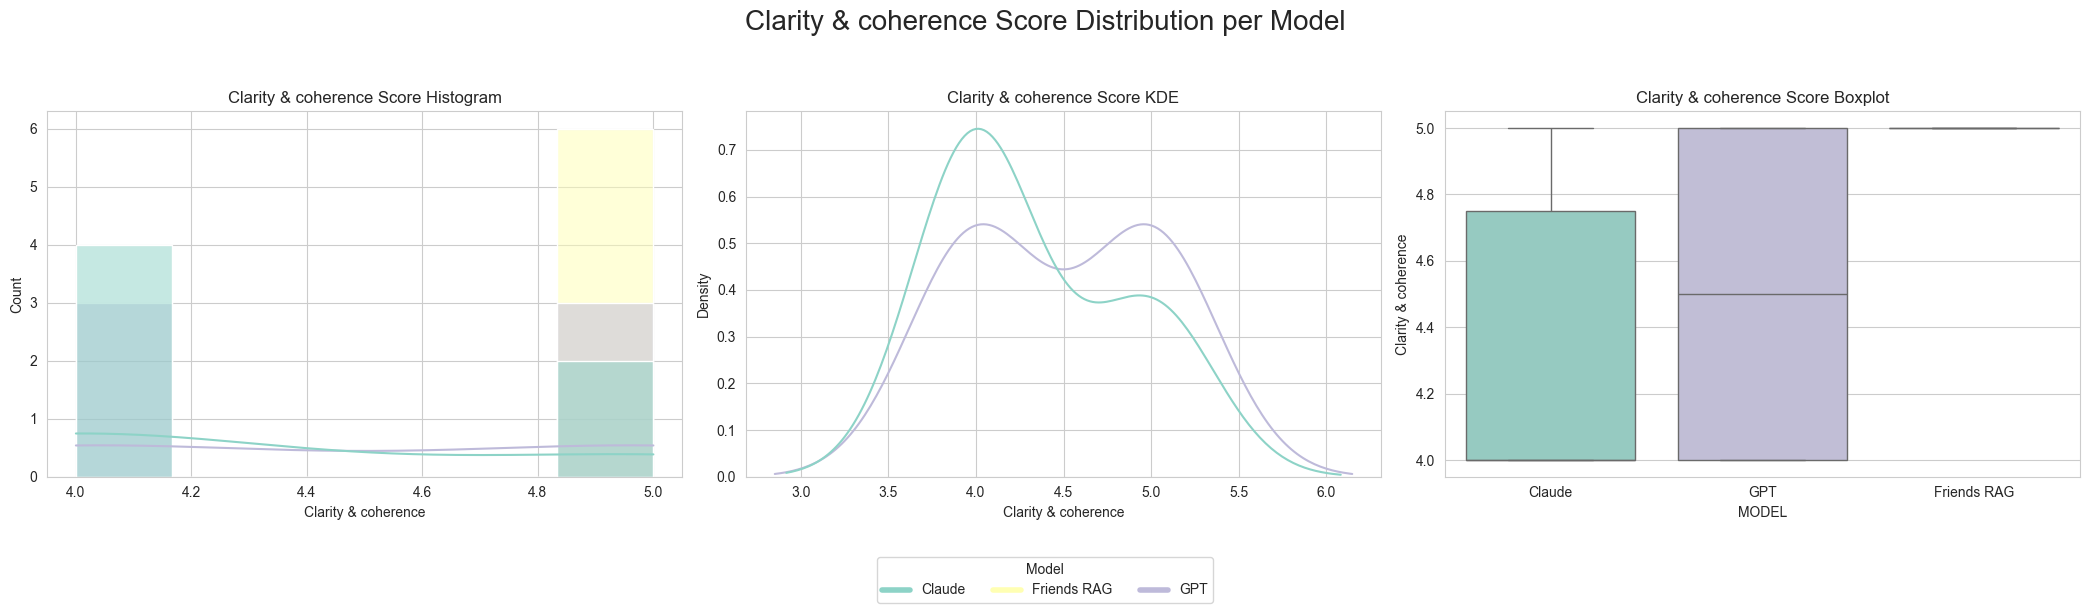

Friends RAG vs Claude - Mann-Whitney U statistic: 312.0, p-value: 0.007194871646910503
Model Friends RAG is significantly better than Model Claude regarding Clarity & coherence
Friends RAG vs GPT - Mann-Whitney U statistic: 237.0, p-value: 0.3353101418524983
Model 'Friends RAG' is not significantly better than Model 'GPT' regarding Clarity & coherence
Service Cancellation Prompts is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 40.5, p-value: 0.5197767383185427
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding Clarity & coherence
Telling a friend you don't want to go into business with them is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 31.5, p-value: 0.012398978234259585
Model Friends RAG is significantly better than Model Claude regarding Clarity & coherence
Friends RAG vs GPT - Mann-Whitney U statistic: 28.5, p-value: 0.02714

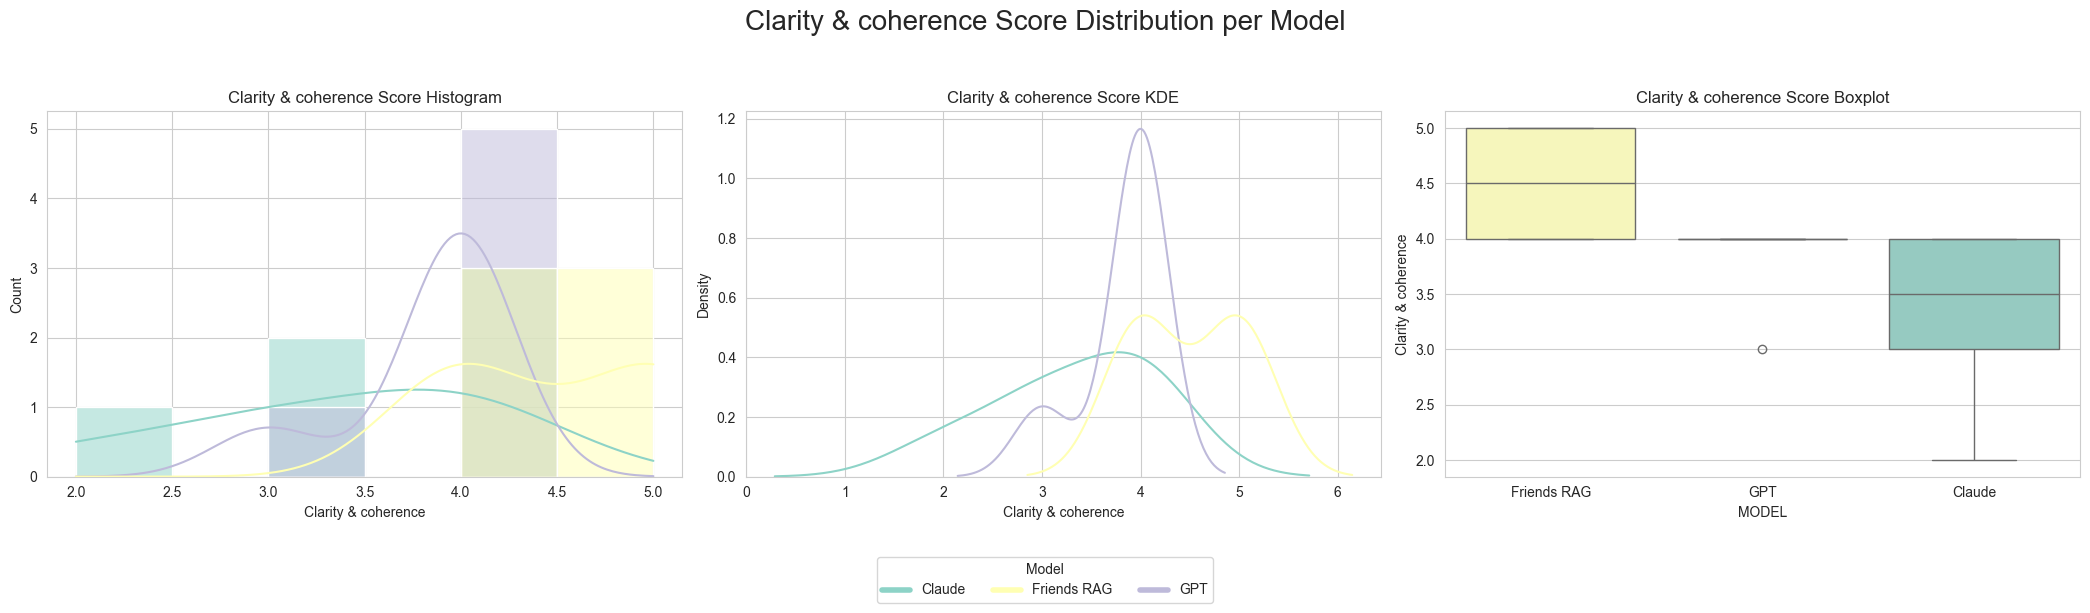

Friends RAG vs Claude - Mann-Whitney U statistic: 24.5, p-value: 0.15911266550951242
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding Clarity & coherence
Telling someone you no longer want to be their bridesmaid/groomsman is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 26.0, p-value: 0.09492701346973698
Model 'Friends RAG' is not significantly better than Model 'Claude' regarding Clarity & coherence
Turning down a family or cultural expectation is not significantly better for Friends RAG than Claude and GPT
Friends RAG vs Claude - Mann-Whitney U statistic: 64.5, p-value: 0.011614466967146813
Model Friends RAG is significantly better than Model Claude regarding Clarity & coherence
Friends RAG vs GPT - Mann-Whitney U statistic: 53.5, p-value: 0.11222469167291782
Model 'Friends RAG' is not significantly better than Model 'GPT' regarding Clarity & coherence
Turning down a job offer or promotion i

In [43]:
for category, category_df in df.groupby('Category'):
    if compare_models(category_df, 'Friends RAG', 'Claude', 'Clarity & coherence') <= 0.05 and compare_models(category_df, 'Friends RAG', 'GPT', 'Clarity & coherence') <= 0.05:
        print(f'Category {category} is significantly better for Friends RAG than Claude and GPT')
        plot_distribution_per_model(category_df, 'Clarity & coherence')
    else:
        print(category + ' is not significantly better for Friends RAG than Claude and GPT')

# Check Annotators Scores

In [44]:
# Calculate the average score per prompt
df['average_score'] = df[[' Human-like rate', 'Response Relevance - rate', 'Clarity & coherence']].mean(axis=1)

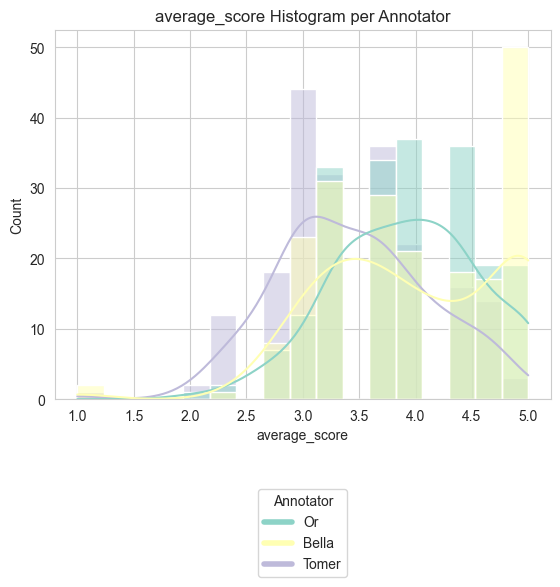

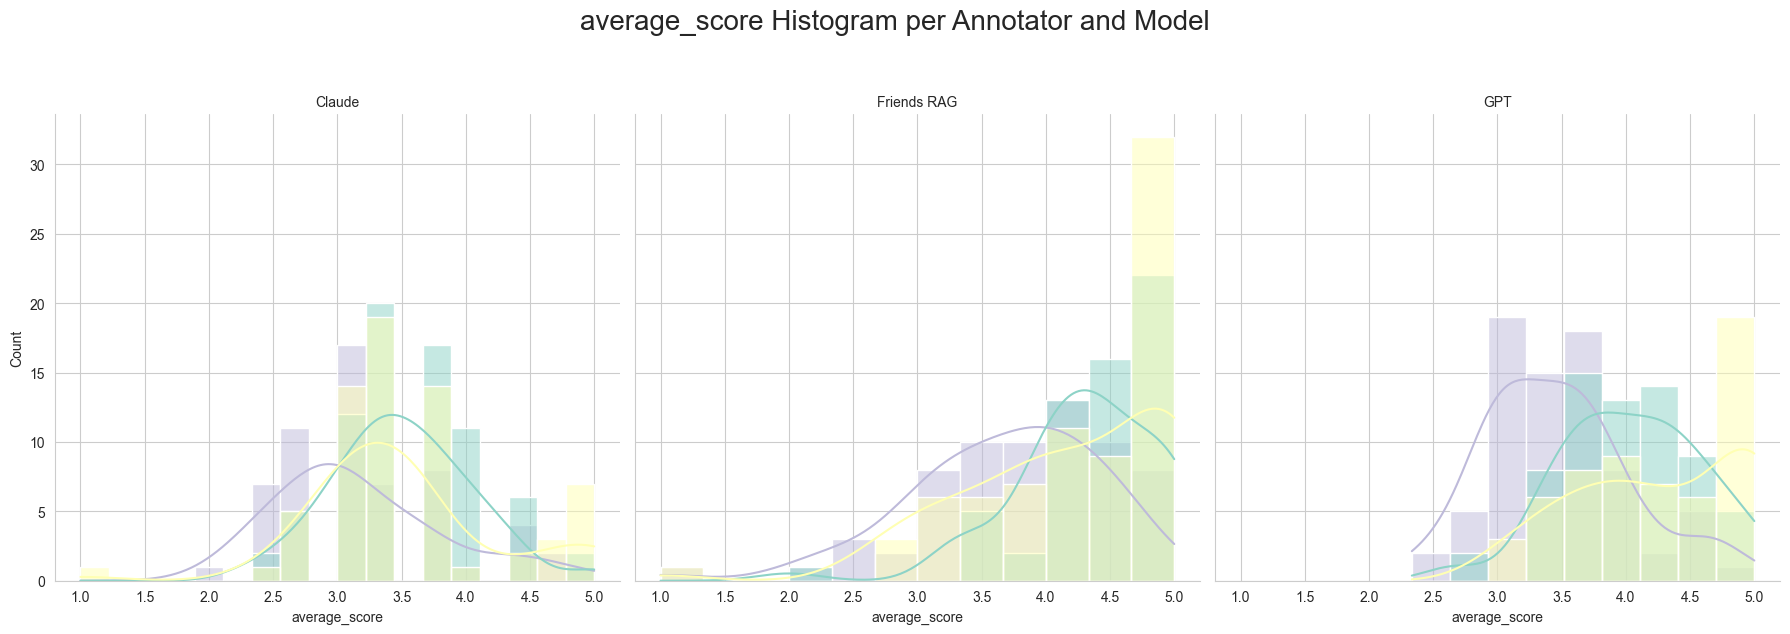

In [45]:
# Compare the annotators' distributions
compare_annotators(df, rate_column='average_score')

In [46]:
# Check P-values for all pairs of annotators
for first_annotator in df['Annotator'].unique():
    for second_annotator in df['Annotator'].unique():
        if first_annotator != second_annotator:
            first_scores = df[df['Annotator'] == first_annotator]['average_score']
            second_scores = df[df['Annotator'] == second_annotator]['average_score']
            stat, p_value = mannwhitneyu(first_scores, second_scores)
            print(f"{first_annotator} vs {second_annotator} - Mann-Whitney U statistic: {stat}, p-value: {p_value}")

Bella vs Or - Mann-Whitney U statistic: 20993.5, p-value: 0.3855856896091131
Bella vs Tomer - Mann-Whitney U statistic: 27614.0, p-value: 3.035747058345546e-11
Or vs Bella - Mann-Whitney U statistic: 19006.5, p-value: 0.3855856896091131
Or vs Tomer - Mann-Whitney U statistic: 27688.5, p-value: 1.9049075267515917e-11
Tomer vs Bella - Mann-Whitney U statistic: 12386.0, p-value: 3.035747058345546e-11
Tomer vs Or - Mann-Whitney U statistic: 12311.5, p-value: 1.9049075267515917e-11


In [48]:
# Check the average scores per annotator
df.groupby('Annotator')['average_score'].describe()

,count,mean,std,min,25%,50%,75%,max
Annotator,,,,,,,,
Bella,200.0,3.978333,0.822002,1.0,3.333333,4.000000,4.750000,5.0
Or,200.0,3.918333,0.644088,2.0,3.333333,4.000000,4.333333,5.0
Tomer,200.0,3.446667,0.688455,1.0,3.000000,3.333333,4.000000,5.0
